In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def replace_age_fraction(df_train):
    df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
    print len(df_train.loc[df_train['Age']<1,'Age'])


In [5]:
def replace_na_to_mode(df_train):
    for i in df_train.columns:
    
        if(i in ['PassengerId','Name']):
            pass
        else:
            print i
            df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

In [6]:
replace_age_fraction(df_train)

0


In [7]:
replace_na_to_mode(df_train)

Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [8]:
import h2o

In [9]:
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.121-b13, mixed mode)
  Starting server from C:\Users\hamza\Anaconda3\envs\gl-env\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: c:\users\hamza\appdata\local\temp\tmpl51yix
  JVM stdout: c:\users\hamza\appdata\local\temp\tmpl51yix\h2o_hamza_started_from_python.out
  JVM stderr: c:\users\hamza\appdata\local\temp\tmpl51yix\h2o_hamza_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 5 days
H2O cluster name:,H2O_from_python_hamza_oafyvc
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [10]:
# upload data to h2o frame
hdf= h2o.H2OFrame(df_train)

# factor the class label
hdf['Survived']= hdf['Survived'].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)


# create input and response column names
response = 'Survived'
input_name= hdf.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


In [11]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [12]:
nfolds =7

In [44]:
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(ntrees=150,
                                      max_depth=5,
                                      min_rows=3,
                                      learn_rate=0.01,
                                      nfolds=7,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.943353576248
valid accuracy: 0.891564603332


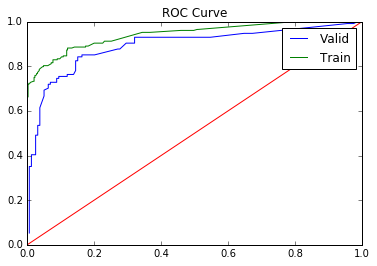

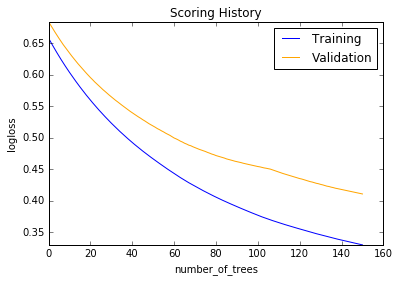

In [45]:
def model_performance(model =  my_gbm):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()

model_performance(my_gbm)
my_gbm.plot()

In [29]:
# Train and cross-validate a DL
my_dl = H2ODeepLearningEstimator(seed =1,  
                              hidden=[200,200,200],
                              epochs =36,
                              l2= 1e-20,
#                               l1=1e-2,
                                 rate = 0.1,
#                                  momentum_start = 0.5,
                              activation = 'MaxoutWithDropout',
                              distribution = 'AUTO',
                              nfolds=5,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_dl.train(x =input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Train accuracy: 0.892155870445
valid accuracy: 0.884309831182


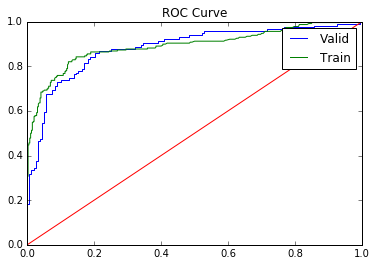

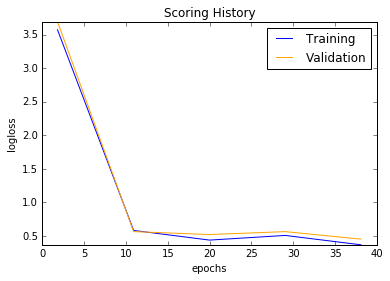

In [30]:
def model_performance(model =  my_dl):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()

model_performance(my_dl)
my_dl.plot()

## Predict with Model 

In [33]:
df_test = pd.read_csv('F:/Titanic/data/test.csv')

replace_age_fraction(df_test)
replace_na_to_mode(df_test)

0
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [34]:
hdf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
def get_prediction(model= my_dl, hdf_data = hdf_test, create_frame=True):
    prediction = model.predict(hdf_data)
    
    if(create_frame == True):
        lst_id=range(892,len(df_test['Age'])+892)

        #initialize dataframe and save prediction values in Survived columns and lst_id in Passenger id coloums
        df_submission = pd.DataFrame()
        df_submission['PassengerId'] = lst_id
        df_submission['Survived'] = prediction['predict'].as_data_frame()
        
        return df_submission

    else:
    #     prediction['predict'].unique()
        return prediction

In [36]:
df_submission = get_prediction(my_dl,hdf_data=hdf_test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [37]:
df_submission.to_csv('F:/Titanic/data/submission.csv',index=False)

In [2]:
# h2o.shutdown()